In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import warnings
warnings.simplefilter('ignore')

import os
from pprint import pprint

import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lightning_module import SegmentModule

In [30]:
# DEVICE = 'cuda:0' if torch.cuda.is_available else 'cpu'
DEVICE = 'cpu'
DATA_PATH = '../data'

In [31]:
# Загружаем модель

checkpoint_name = '..\\experiments\\unet_resnet34_d_f_320\\epoch_epoch=27-val_IoU=0.889.ckpt'
module = SegmentModule.load_from_checkpoint(checkpoint_name, map_location=torch.device('cpu'))

_ = module.eval()
_ = module.to(DEVICE)

In [32]:
# Загружаем данные
df = pd.read_csv('..\\data\\df_test.csv')
names = list(df.columns[1:])
names
df.head(2)

['x_from', 'y_from', 'width', 'height']

,filename,x_from,y_from,width,height
0,images/fb1ec415-58e8-4374-97a9-d0e37fd5a225--r...,48,617,496,338
1,images/e97ed90b-6c78-43ee-9d63-e145f65c1eb7--r...,322,619,458,219


In [33]:
# препроцессинг данных 
from augmentations import get_transforms
test_transforms = get_transforms(width=320, height=320, encoder = 'resnet34', augmentations=False)

In [42]:
def mask_postprocesing(prob_mask, threshold):
    mask = (prob_mask > threshold).astype(np.uint8)
    mask = mask.transpose(1, 2, 0)
    num_labels, labels_im = cv2.connectedComponents(mask)
    max_size = 0
    max_label = 0
    for label in range(1, num_labels):
        component = (labels_im == label).astype(np.uint8)
        size = cv2.countNonZero(component)
        if size > max_size:
            max_size = size
            max_label = label

    largest_component_mask = (labels_im == max_label).astype(np.uint8)

    largest_component_mask = (largest_component_mask > 0).astype(np.uint8)
    return largest_component_mask

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


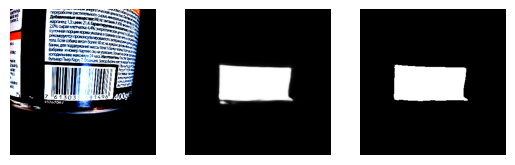

In [45]:
idx = 10
image_name = os.path.normpath(os.path.join(DATA_PATH, df["filename"][idx]))
image = cv2.imread(image_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
procecces_image = test_transforms(image=image)['image']
procecces_image = procecces_image.float()
with torch.no_grad():
    prob_mask = torch.sigmoid(module(procecces_image[None].to(DEVICE)))[0].cpu().numpy()
    
mask = mask_postprocesing(prob_mask, 0.5)
procecces_image = procecces_image.permute(1, 2, 0)
plt.subplot(1,3,1)
plt.axis("off")
plt.imshow(procecces_image.squeeze())
plt.subplot(1,3,2)
plt.axis("off")
plt.imshow(prob_mask.squeeze(), cmap='gray')
plt.subplot(1,3,3)
plt.axis("off")
plt.imshow(mask.squeeze(), cmap='gray')
plt.show();